<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score,plot_roc_curve,roc_curve
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt

In [ ]:
n_repeats=1
n_splits=5

In [ ]:
path_to_max_label="../content/max_label.csv"
path_to_app="../content/cleaned_application.csv"
cleaned_app_df=pd.read_csv(path_to_app,index_col=0)
max_df=pd.read_csv(path_to_max_label,index_col=0)

In [ ]:
dep_var="status"
random_state=42

preprocessing the same as other model notebook.

In [ ]:
order=cleaned_app_df.groupby("job")["income"].median().sort_values()

In [ ]:
cleaned_app_df["job"]=cleaned_app_df["job"].replace(order)

In [ ]:
train_df=max_df.merge(cleaned_app_df,how="inner",on="id").drop("id",axis=1)

In [ ]:
numerical_transformer = StandardScaler()
categorical_transformer=OneHotEncoder()
ord_transformer=OrdinalEncoder()

In [ ]:
X,y=train_df.drop(columns=dep_var),train_df[dep_var]

In [ ]:
categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord',ord_transformer,['job'])
    ])

In [ ]:
xs=preprocessor.fit_transform(X)

In [ ]:
score_df=pd.DataFrame()

cv same

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [ ]:
# dataframe of scores to be converted into plot later
score_df=pd.DataFrame()

In [ ]:
import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
def scheduler(epoch, lr):
          if epoch < 10:
            return lr
          else:
            return lr * tf.math.exp(-0.1)
#Use BinaryFocalCrossentropy instead of BinaryCrossentropy
loss= tf.keras.losses.BinaryFocalCrossentropy()
# we can use AUC and PR metric
metrics = [tf.keras.metrics.AUC(curve='ROC')]
def createModel(loss,optimizer,metrics):
    model= keras.Sequential([
      keras.layers.Dense(1024,activation="relu"),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(512,activation="relu"),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(256,activation="relu"),
      keras.layers.Dense(128,activation="relu"),
      keras.layers.Dense(1,activation="sigmoid")])
    model.compile(loss=loss,optimizer=optimizer, metrics=metrics)
    return model

In [118]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      #Adam > SGD
      opt = tf.optimizers.Adam(learning_rate=0.001)
      model= createModel(loss=loss,optimizer=opt, metrics=metrics)
      schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
      earlystop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
      callbacks=[schedule,earlystop]
      class_w= dict(zip(np.unique(y_train),compute_class_weight("balanced",classes=np.unique(y_train),y=y_train)))
      history=model.fit(X_train, y_train,batch_size=64, epochs=100,validation_data=(X_test,y_test),verbose=1,callbacks=callbacks,class_weight=class_w)
      y_pred = model.predict(X_test,verbose=0)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data,besthistory=score,[y_test,X_test],history
            print(f"NN with best score of {score}")
score_df["NN"]=scores
print(f"NN with avg score of {np.median(np.array(scores))}")

Epoch 1/100
456/456 [==============================] - 5s 9ms/step - loss: 0.6952 - auc_2: 0.5727 - val_loss: 0.6668 - val_auc_2: 0.5326 - lr: 0.0010
Epoch 2/100
456/456 [==============================] - 4s 9ms/step - loss: 0.6903 - auc_2: 0.5456 - val_loss: 0.6596 - val_auc_2: 0.5702 - lr: 0.0010
Epoch 3/100
456/456 [==============================] - 4s 8ms/step - loss: 0.6866 - auc_2: 0.5621 - val_loss: 0.6812 - val_auc_2: 0.5702 - lr: 0.0010
Epoch 4/100
456/456 [==============================] - 4s 9ms/step - loss: 0.6820 - auc_2: 0.5813 - val_loss: 0.6524 - val_auc_2: 0.5805 - lr: 0.0010
Epoch 5/100
456/456 [==============================] - 4s 9ms/step - loss: 0.6755 - auc_2: 0.6007 - val_loss: 0.7099 - val_auc_2: 0.6077 - lr: 0.0010
Epoch 6/100
456/456 [==============================] - 4s 9ms/step - loss: 0.6693 - auc_2: 0.6187 - val_loss: 0.6594 - val_auc_2: 0.6109 - lr: 0.0010
Epoch 7/100
456/456 [==============================] - 4s 9ms/step - loss: 0.6604 - auc_2: 0.6332 - 

KeyboardInterrupt: 

In [119]:
y_test,X_test=bestmodel_val_data
y_prob=bestmodel.predict(X_test)
fpr , tpr , thresholds = roc_curve (y_test ,y_prob)
auc_score=roc_auc_score(y_test,y_prob)  

228/228 [==============================] - 1s 3ms/step


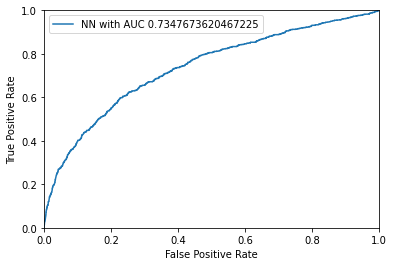

In [120]:
#https://androidkt.com/get-the-roc-curve-and-auc-for-keras-model/
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr,label=f"NN with AUC {auc_score}") 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  plt.show()    
plot_roc_curve (fpr,tpr) 

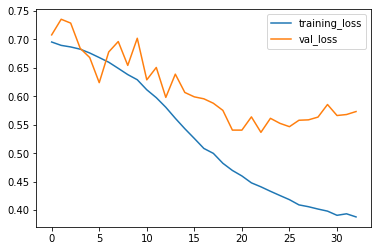

In [123]:
plt.plot(besthistory.history["loss"],label="training_loss")
plt.plot(besthistory.history["val_loss"],label="val_loss")
plt.legend()

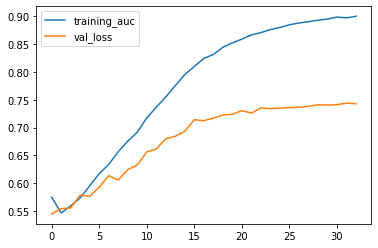

In [124]:
plt.plot(besthistory.history["auc_2"],label="training_auc")
plt.plot(besthistory.history["val_auc_2"],label="val_auc")
plt.legend()

In [ ]:
score_df.to_csv("../content/score_nn.csv")

In [ ]:
# classes are balanced ,we use BCE
loss= keras.losses.BinaryCrossentropy()
earlystop=keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
callbacks=[schedule,earlystop]

In [ ]:
score_df_smote=pd.DataFrame()

In [ ]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      opt = tf.optimizers.Adam(learning_rate=0.001)
      model= createModel(loss=loss,optimizer=opt, metrics=metrics)
      sm=SMOTE()
      X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
      schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
      earlystop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
      callbacks=[schedule,earlystop]
      history=model.fit(X_train_oversampled,y_train_oversampled,batch_size=64, epochs=100,validation_data=(X_test,y_test),verbose=1,callbacks=callbacks)
      y_pred = model.predict(X_test,verbose=0)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data,besthistory=score,[y_test,X_test],history
            print(f"NN with best score of {score}")
score_df_smote["NN_Smote"]=scores

In [ ]:
y_test,X_test=bestmodel_val_data
y_prob=bestmodel.predict(X_test)
fpr , tpr , thresholds = roc_curve (y_test ,y_prob)
auc_score=roc_auc_score(y_test,y_prob)  
plot_roc_curve (fpr,tpr) 

In [ ]:
plt.plot(besthistory.history["loss"],label="training_loss")
plt.plot(besthistory.history["val_loss"],label="val_loss")
plt.legend()

In [ ]:
plt.plot(besthistory.history["auc_2"],label="training_auc")
plt.plot(besthistory.history["val_auc_2"],label="val_auc")
plt.legend()

In [ ]:
score_df_smote.to_csv("../content/score_nn_smote.csv")

In [ ]:
score_df_tl=pd.DataFrame()

In [ ]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      opt = tf.optimizers.Adam(learning_rate=0.001)
      model= createModel(loss=loss,optimizer=opt, metrics=metrics)
      tl=TomekLinks()
      schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
      earlystop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
      callbacks=[schedule,earlystop]
      X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
      history=model.fit(X_train_undersampled,y_train_undersampled,batch_size=64, epochs=100,validation_data=(X_test,y_test),verbose=1,callbacks=callbacks)
      y_pred = model.predict(X_test,verbose=0)
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data,besthistory=score,[y_test,X_test],history
            print(f"NN with best score of {score}")
score_df_tl["NN_tl"]=scores

In [ ]:
y_test,X_test=bestmodel_val_data
y_prob=bestmodel.predict(X_test)
fpr , tpr , thresholds = roc_curve (y_test ,y_prob)
auc_score=roc_auc_score(y_test,y_prob)  
plot_roc_curve (fpr,tpr) 

We use the latest model to demostrate the loss and AUC over epochs

In [ ]:
plt.plot(besthistory.history["loss"],label="training_loss")
plt.plot(besthistory.history["val_loss"],label="val_loss")
plt.legend()

In [ ]:
plt.plot(besthistory.history["auc_2"],label="training_auc")
plt.plot(besthistory.history["val_auc_2"],label="val_auc")
plt.legend()

All the NN are overfitting as seen from the difference between the training loss and val loss

In [ ]:
score_df_tl.to_csv("../content/score_nn_tl.csv")